In [1]:
import pandas as pd

In [17]:
df = pd.read_csv("/data/twitter/supervised/sentiment.csv", delimiter=",adsf,asdf", names=['values'], skiprows=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [26]:
type(df['values'].str.split(","))

pandas.core.series.Series

In [61]:
dff = pd.DataFrame(df['values'].str.split(",", 3).tolist(), columns=['id', 'sentiment', 'source', 'tweet'])

In [62]:
dff[['source', 'sentiment', 'id']].groupby(['sentiment', 'source']).count()

id
sentiment source              
0         Kaggle           620
          Sentiment140  787822
1         Kaggle           729
          Sentiment140  789456

In [63]:
import numpy as np
token_index = {}
samples = dff.tweet.tolist()
for sample in samples:
    # We simply tokenize the samples via the `split` method.
    # in real life, we would also strip punctuation and special characters
    # from the samples.
    for word in sample.split():
        if word not in token_index:
            # Assign a unique index to each unique word
            token_index[word] = len(token_index) + 1
            # Note that we don't attribute index 0 to anything.

# Next, we vectorize our samples.
# We will only consider the first `max_length` words in each sample.
max_length = 10

In [110]:
print(max(token_index.values()) + 1)
print(len(samples))

1450957
1578627


In [60]:
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

MemoryError: 

In [90]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 50  # Keep tweets to 50 words or less
training_samples = 250  # Train on 250 samples, more likely to cause memory error
validation_samples = 10000  # Validation dataset has 10000 samples
max_words = 10000  # Consider top 10000 most frequent words
tweets = dff.tweet.tolist()
sentiment = dff.sentiment.tolist()
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(sentiment)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Found 691202 unique tokens.
Shape of data tensor: (1578627, 50)
Shape of label tensor: (1578627,)


In [91]:
# https://keras.io/layers/embeddings/
# http://colah.github.io/posts/2015-08-Understanding-LSTMs/

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
embedding_dim = 64
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 64)            640000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                102432    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 742,465
Trainable params: 742,465
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('model.h5')

Train on 250 samples, validate on 10000 samples
Epoch 1/25
250/250 [==============================] - 1s 3ms/step - loss: 0.1176 - acc: 0.9840 - val_loss: 0.7983 - val_acc: 0.5310
Epoch 2/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0787 - acc: 0.9960 - val_loss: 0.7329 - val_acc: 0.5523
Epoch 3/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0622 - acc: 0.9920 - val_loss: 0.7243 - val_acc: 0.5605
Epoch 4/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0457 - acc: 0.9960 - val_loss: 0.7514 - val_acc: 0.5543
Epoch 5/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0353 - acc: 0.9960 - val_loss: 0.7721 - val_acc: 0.5514
Epoch 6/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0309 - acc: 0.9960 - val_loss: 0.7582 - val_acc: 0.5621
Epoch 7/25
250/250 [==============================] - 1s 3ms/step - loss: 0.0247 - acc: 0.9920 - val_loss: 0.8344 - val_acc: 0.5418
Epoch 8/25
250/250 [========

In [94]:
dff.shape

(1578627, 4)

In [95]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


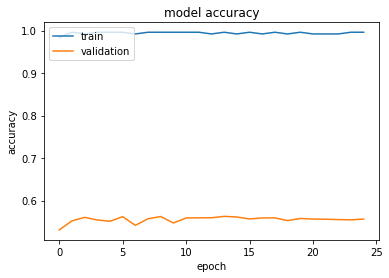

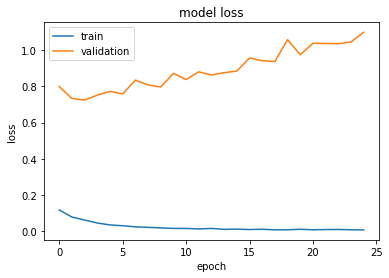

In [96]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras import regularizers
from keras import layers

embedding_dim = 64
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Dropout(0.5))
model.add(Flatten())
model.add(layers.Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 64)            640000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                102432    
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total para

In [104]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 250 samples, validate on 10000 samples
Epoch 1/10
250/250 [==============================] - 1s 5ms/step - loss: 0.6955 - acc: 0.5200 - val_loss: 0.6931 - val_acc: 0.5034
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.6880 - acc: 0.5120 - val_loss: 0.6951 - val_acc: 0.5032
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.6896 - acc: 0.5360 - val_loss: 0.6925 - val_acc: 0.5053
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.6842 - acc: 0.5880 - val_loss: 0.6927 - val_acc: 0.5044
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.6781 - acc: 0.5880 - val_loss: 0.6950 - val_acc: 0.5032
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.6723 - acc: 0.5960 - val_loss: 0.6966 - val_acc: 0.5032
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 0.6805 - acc: 0.5680 - val_loss: 0.6921 - val_acc: 0.5063
Epoch 8/10
250/250 [========

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


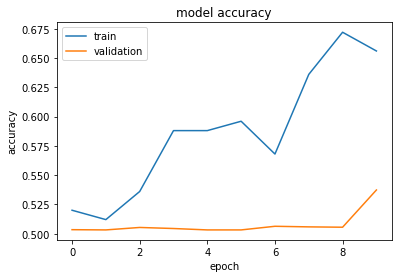

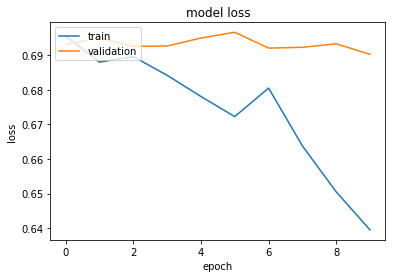

In [105]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [108]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=100,print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 250 samples, validate on 10000 samples
Epoch 1/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6956 - acc: 0.5080 - val_loss: 0.6940 - val_acc: 0.5031
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6894 - acc: 0.5240 - val_loss: 0.6928 - val_acc: 0.5074
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6904 - acc: 0.5240 - val_loss: 0.6928 - val_acc: 0.5072
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6769 - acc: 0.6000 - val_loss: 0.6927 - val_acc: 0.5074
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6743 - acc: 0.6160 - val_loss: 0.6928 - val_acc: 0.5067
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6642 - acc: 0.6240 - val_loss: 0.6937 - val_acc: 0.5045
Epoch 7/100
250/250 [==============================] - 1s 3ms/step - loss: 0.6483 - acc: 0.6840 - val_loss: 0.6920 - val_acc: 0.5165
Epoch 8/100
250/250 [

Epoch 62/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0110 - acc: 0.9960 - val_loss: 1.0542 - val_acc: 0.5602
Epoch 63/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0214 - acc: 0.9880 - val_loss: 1.0729 - val_acc: 0.5619
Epoch 64/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0095 - acc: 0.9960 - val_loss: 1.0825 - val_acc: 0.5599
Epoch 65/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 1.1008 - val_acc: 0.5604
Epoch 66/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0065 - acc: 0.9960 - val_loss: 1.1170 - val_acc: 0.5602
Epoch 67/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0125 - acc: 0.9960 - val_loss: 1.1370 - val_acc: 0.5620
Epoch 68/100
250/250 [==============================] - 1s 3ms/step - loss: 0.0205 - acc: 0.9920 - val_loss: 1.1481 - val_acc: 0.5603
Epoch 69/100
250/250 [==============================] - 1s 3ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


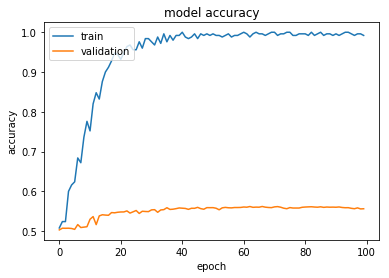

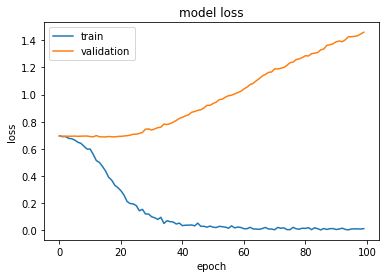

In [109]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()